# Linear Regression Training Notebook

This notebook trains a linear regression model to predict the **Bitcoin price** based on Fear & Greed Index data. It includes automated model versioning for managing challenger and champion models.

## Imports 

In [11]:
import polars as pl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('./src')
from model_io import save_model


## Load and Prepare Data
Read the processed Parquet data, sort by time, and prepare features and targets for model training.

In [12]:
data_path = '../data/processed/fear_and_greed_history_5min.parquet'
df = pl.read_parquet(data_path).sort('interval_end_time')

# Prepare data for training
# Feature: Fear & Greed Index, Target: BTC price
X = df.select('avg_actual_value').to_numpy()  # Fear & Greed Index
y = df.select('close_bitcoin_price_usd').to_numpy().flatten()  # BTC price

# Train-test split (80%-20% split)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## Train and Evaluate Model
Train a linear regression model on the training data and evaluate its performance on the test set.

In [13]:

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')


Mean Squared Error: 3443768.6982


## Model Versioning and Saving
Save the trained model weights and metadata, and manage champion/challenger logic for model versioning.

In [14]:
# Prepare weights DataFrame
weights_df = pl.DataFrame({
    'feature': ['intercept', 'fear_greed_index'],
    'weight': [model.intercept_, model.coef_[0]]
})

# Use the utility function to save the model and handle versioning
result_msg = save_model(weights_df, mse, '../models')
print(result_msg)


Challenger model saved (not champion).


## Visualize Data and Model Predictions
Visualize the relationship between Bitcoin price and the Fear & Greed Index, and compare actual vs. predicted values after training.

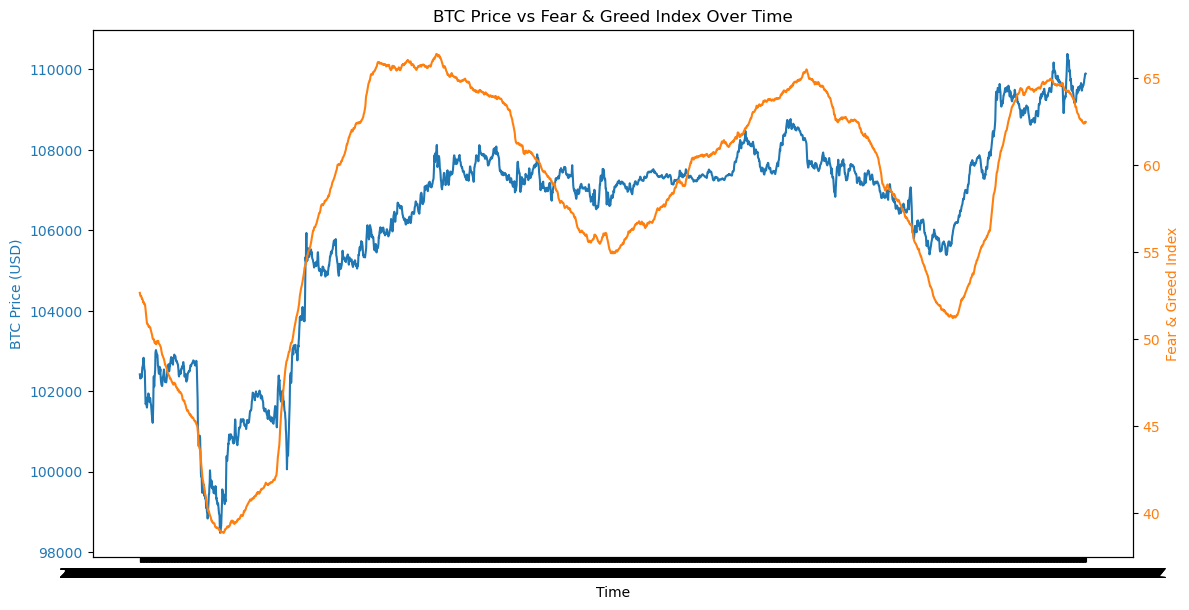

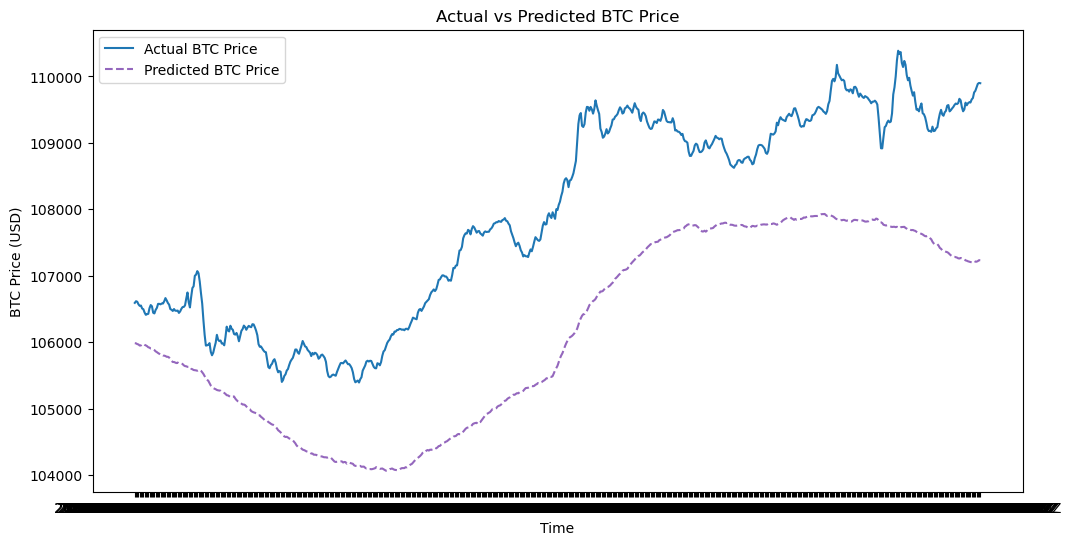

In [15]:
import matplotlib.pyplot as plt

def plot_btc_vs_fear_greed(df):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('BTC Price (USD)', color=color)
    ax1.plot(df['interval_end_time'].to_numpy(), df['close_bitcoin_price_usd'].to_numpy(), color=color, label='BTC Price')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Fear & Greed Index', color=color)
    ax2.plot(df['interval_end_time'].to_numpy(), df['avg_actual_value'].to_numpy(), color=color, label='Fear & Greed Index')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('BTC Price vs Fear & Greed Index Over Time')
    plt.show()

# Visualize the data before training
plot_btc_vs_fear_greed(df)

# After training, plot actual vs predicted BTC price
plt.figure(figsize=(12, 6))
plt.plot(df['interval_end_time'].to_numpy()[split_idx:], y_test, label='Actual BTC Price', color='tab:blue')
plt.plot(df['interval_end_time'].to_numpy()[split_idx:], y_pred, label='Predicted BTC Price', color='tab:purple', linestyle='--')
plt.xlabel('Time')
plt.ylabel('BTC Price (USD)')
plt.title('Actual vs Predicted BTC Price')
plt.legend()
plt.show()
